In [1]:
import cv2
import cv3.cv2 as cv3
import numpy as np
import  matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

datapath = "D:/objRecognition/CarData/TrainImages"
POS = 'pos-'
NEG = 'neg-'

def rgbImg(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def path(cls,i):
    return "%s/%s%d.pgm"  % (datapath,cls,i+1)

def getImg(cls,i):
    return cv2.imread("{}/{}{}.pgm".format("D:/objRecognition/CarData/TrainImages", cls, i+1), 0)

def resize(img, scaleFactor):
    return cv2.resize(img, (int(img.shape[1] * (1 / scaleFactor)), int(img.shape[0] * (1 / scaleFactor))), 
                      interpolation=cv2.INTER_AREA)

def get_pyramid(image, scaleFactor=1.5, minSize=(200, 80)):
    yield image
    if type(scaleFactor) != float:
        raise TypeError, 'scaleFactor only accepted float'
    while True:
        image = resize(image, scaleFactor)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image
    
def sliding_window(image, stepSize, windowSize):
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def area(box):
    return (abs(box[2] - box[0])) * (abs(box[3] - box[1]))

def overlaps(a, b, thresh):
    #print "checking overlap "
    #print a, b
    x1 = np.maximum(a[0], b[0])
    x2 = np.minimum(a[2], b[2])
    y1 = np.maximum(a[1], b[1])
    y2 = np.minimum(a[3], b[3])
    intersect = float(area([x1, y1, x2, y2]))
    return intersect / np.minimum(area(a), area(b)) >= thresh

def is_inside(rec1, rec2):
    def inside(a,b):
        if (a[0] >= b[0]) and (a[2] <= b[0]):
            return (a[1] >= b[1]) and (a[3] <= b[3])
        else:
            return False
    return (inside(rec1, rec2) or inside(rec2, rec1))

def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("float")

def car_detector():
    detector = cv2.SIFT()
    extractor = cv2.DescriptorExtractor_create('SIFT')

    K = 12
    bow_kmeans_trainer = cv2.BOWKMeansTrainer(K)

    FLANN_INDEX_KDTREE = 1
    flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(flann_params, search_params)
    bow_extractor = cv2.BOWImgDescriptorExtractor(extractor, matcher)
    
    SAMPLES_NUM = 10
    for i in xrange(0, SAMPLES_NUM):
        pos_img = getImg(POS, i)
        pos_keypoints = detector.detect(pos_img)
        extracted_pos_keypoints, extracted_pos_descriptors = extractor.compute(pos_img, pos_keypoints)
        if extracted_pos_descriptors is not None:
            bow_kmeans_trainer.add(extracted_pos_descriptors)

    vocabulary = bow_kmeans_trainer.cluster()
    bow_extractor.setVocabulary(vocabulary)

    traindata, trainlabels = [],[]
    for i in xrange(0, 400):
        pos_img = getImg(POS, i)
        pos_keypoints = detector.detect(pos_img)
        extracted_pos_keypoints, extracted_pos_descriptors = extractor.compute(pos_img, pos_keypoints)
        bow_pos_keypoints = bow_extractor.compute(pos_img, extracted_pos_keypoints)
        if bow_pos_keypoints is not None:
            traindata.extend(bow_pos_keypoints)
            trainlabels.append(1)

        neg_img = getImg(NEG, i)
        neg_keypoints = detector.detect(neg_img)
        extracted_neg_keypoints, extracted_neg_descriptors = extractor.compute(neg_img, neg_keypoints)
        bow_neg_keypoints = bow_extractor.compute(neg_img, extracted_neg_keypoints)
        if bow_neg_keypoints is not None:
            traindata.extend(bow_neg_keypoints)
            trainlabels.append(-1)

    #svm_param = dict(svm_type=cv2.SVM_C_SVC, kernel_type=cv2.SVM_RBF, gamma=1.0, Cvalue=35)
    svm_param = dict(svm_type=cv2.SVM_C_SVC, kernel_type=cv2.SVM_LINEAR, gamma=0.1, Cvalue=30)
    SVM = cv2.SVM()
    SVM.train(np.array(traindata), np.array(trainlabels), params=svm_param)
    SVM.save('D:/objRecognition/car_model')
    return SVM, bow_extractor

def in_range(number, test, thresh=0.2):
    return abs(number - test) < thresh

def get_imhist(obj):
    if type(obj) == str:
        img = cv2.imread(path)
    else:
        img = obj
    #resized= cv2.resize(img, (100,100))
    HSV_ROI = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    ROI_HIST = cv2.calcHist([HSV_ROI], [0], None, [180], [0,180])
    Hist = ROI_HIST.copy()
    cv2.normalize(ROI_HIST, Hist, 0, 255, cv2.NORM_MINMAX)
    return Hist

def get_RGBhist(obj):
    if type(obj) == str:
        img = cv2.imread(path)
    else:
        img = obj

    B = cv2.calcHist([img], [0], None, [255], [0,255])
    cv2.normalize(B, 0, 255, cv2.NORM_MINMAX)
    G = cv2.calcHist([img], [1], None, [255], [0,255])
    cv2.normalize(G, 0, 255, cv2.NORM_MINMAX)
    R = cv2.calcHist([img], [2], None, [255], [0,255])
    cv2.normalize(R, 0, 255, cv2.NORM_MINMAX)
    return np.append(np.append(B, G), R)


def get_contour_parm(contour):
    """Coordinators of contour will be transformed to (x, y, w, h)"""
    min_rect = cv2.minAreaRect(contour)
    box = np.int0(cv2.cv.BoxPoints(min_rect))
    rec_sum = box.sum(axis=1)
    point1 = box[np.argmin(rec_sum)]
    point2 = box[np.argmax(rec_sum)]
    #print point1[0], point1[1], point2[0]-point1[0], point2[1]-point1[1]
    return [point1[0], point1[1], point2[0]-point1[0], point2[1]-point1[1]]

shape (197L, 349L, 3L)


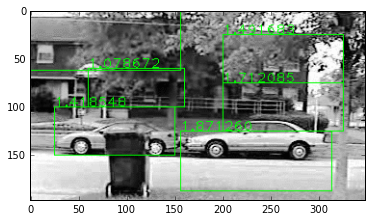

In [446]:
#file_path = 'D:/objRecognition/CarData/test.jpg'
file_path = 'D:/objRecognition/CarData/TestImages_Scale/test-104.pgm'
#file_path = "D:/objRecognition/CarData/TrainImages/pos-497.pgm"
font = cv2.FONT_HERSHEY_PLAIN

svm, bow_extractor = car_detector()
#SVM = cv2.SVM()
#SVM.load('D:/objRecognition/car_model')
detector = cv2.SIFT()

w, h = 100, 40
img = cv2.imread(file_path)
print 'shape', img.shape
rectangles = []
counter = 1
scaleFactor = 1.25
scale = 1

for resized in get_pyramid(img, scaleFactor):  
    scale = float(img.shape[1]) / float(resized.shape[1])
    for (x, y, roi) in sliding_window(resized, 20, (100, 40)):
        #plt.imshow(roi)
        #plt.show()
        if roi.shape[1] != w or roi.shape[0] != h:
            continue

        try:
            keypoints = detector.detect(roi)
            extracted_keypoints = bow_extractor.compute(roi, keypoints)
            result = SVM.predict(extracted_keypoints, returnDFVal=True)
            #print result
            if result < -1.0:
                rx, ry, rx2, ry2 = int(x * scale), int(y * scale), int((x+w) * scale), int((y+h) * scale)
                rectangles.append([rx, ry, rx2, ry2, abs(result)])
        except Exception as e:
            pass

    counter += 1
    
windows = np.array(rectangles)
boxes = non_max_suppression(windows, overlapThresh=0.05)

for (x, y, x2, y2, result) in boxes:
    #print x, y, x2, y2, result
    cv2.rectangle(img, (int(x),int(y)),(int(x2), int(y2)),(0, 255, 0), 1)
    cv2.putText(img, "%f" % result, (int(x),int(y)), font, 1, (0, 255, 0))

plt.imshow(img)
plt.show()

In [447]:
cv2.imwrite('D:/objRecognition/output/car_deteced_05.jpg', img)

True

In [368]:
detector = cv2.SIFT()
extractor = cv2.DescriptorExtractor_create('SIFT')

bow_dict_size = 12
bow_kmeans_trainer = cv2.BOWKMeansTrainer(bow_dict_size)

FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
matcher = cv2.FlannBasedMatcher(flann_params, search_params)
bow_extractor = cv2.BOWImgDescriptorExtractor(extractor, matcher)

for i in xrange(0, 400):
    pos_img = getImg(POS, i)
    pos_keypoints = detector.detect(pos_img)
    extracted_pos_keypoints, extracted_pos_descriptors = extractor.compute(pos_img, pos_keypoints)
    if extracted_pos_descriptors is not None:
        bow_kmeans_trainer.add(extracted_pos_descriptors)
    
    #neg_img = getImg(NEG, i)
    #neg_keypoints = detector.detect(neg_img)
    #extracted_neg_keypoints, extracted_neg_descriptors = extractor.compute(neg_img, neg_keypoints)
    #if extracted_neg_descriptors is not None:
        #bow_kmeans_trainer.add(extracted_neg_descriptors)
vocabulary = bow_kmeans_trainer.cluster()
bow_extractor.setVocabulary(vocabulary)

traindata, trainlabels = [],[]
for i in xrange(0, 400):
    pos_img = getImg(POS, i)
    pos_keypoints = detector.detect(pos_img)
    extracted_pos_keypoints, extracted_pos_descriptors = extractor.compute(pos_img, pos_keypoints)
    bow_pos_keypoints = bow_extractor.compute(pos_img, extracted_pos_keypoints)
    if bow_pos_keypoints is not None:
        traindata.extend(bow_pos_keypoints)
        trainlabels.append(1)
    
    neg_img = getImg(NEG, i)
    neg_keypoints = detector.detect(neg_img)
    extracted_neg_keypoints, extracted_neg_descriptors = extractor.compute(neg_img, neg_keypoints)
    bow_neg_keypoints = bow_extractor.compute(neg_img, extracted_neg_keypoints)
    if bow_neg_keypoints is not None:
        traindata.extend(bow_neg_keypoints)
        trainlabels.append(-1)

svm_param = dict(svm_type=cv2.SVM_C_SVC, kernel_type=cv2.SVM_RBF, gamma=0.5, Cvalue=30)
SVM = cv2.SVM()
SVM.train(np.array(traindata), np.array(trainlabels), params=svm_param)
SVM.save('D:/objRecognition/car_model')
print 'FINISH'

FINISH


In [319]:
voc = bow_extractor.getVocabulary()
voc.shape

(60L, 128L)

(40L, 100L, 3L)
-0.565223515034


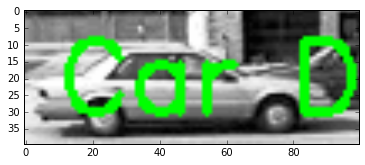

In [383]:
detector = cv2.SIFT()
extractor = cv2.DescriptorExtractor_create('SIFT')

#file_path = 'D:/objRecognition/CarData/TestImages/test-10.pgm'
file_path = "D:/objRecognition/CarData/TrainImages/pos-497.pgm"
#file_path = 'D:/objRecognition/CarData/TestImages_Scale/test-0.pgm'

img = cv2.imread(file_path)

keypoints = detector.detect(img)
extracted_keypoints = bow_extractor.compute(img, keypoints)

SVM = cv2.SVM()
SVM.load('D:/objRecognition/car_model')
prediction = SVM.predict(extracted_keypoints, True)
   
#prediction =  predict(img, extract_bow, detector)
print img.shape
print prediction

font = cv2.FONT_HERSHEY_SIMPLEX
if prediction <= -0.3:
    cv2.putText(img,'Car Detected',(10,30), font, 1,(0,255,0),2)

plt.imshow(img)
plt.show()

In [328]:
detector = cv2.SIFT()
extractor = cv2.DescriptorExtractor_create('SIFT')
counting = 0
SVM = cv2.SVM()
SVM.load('D:/objRecognition/car_model')

for i in range(170):
    file_path = 'D:/objRecognition/CarData/TestImages/test-{}.pgm'.format(i)
    img = cv2.imread(file_path)

    keypoints = detector.detect(img)
    extracted_keypoints = bow_extractor.compute(img, keypoints) 
    prediction = SVM.predict(extracted_keypoints)

    if prediction == -1:
        counting += 1
        #plt.imshow(img)
        #plt.show()
print (170 - counting)/170.0*100, '%'

40.0 %


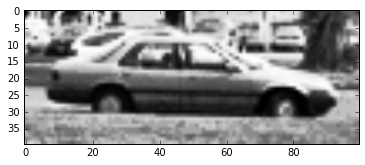

In [198]:
img = getImg(POS, 128)
plt.imshow(img, 'gray')
plt.show()

[[  5.   2.   6. ...,  54.   0.   0.]
 [  2.   4.   2. ...,   0.   0.   7.]
 [ 12.  13.   2. ...,   8.   8.   5.]
 ..., 
 [  3.   4.   4. ...,   3.   1.   3.]
 [  0.   0.   0. ...,   8.   6.   6.]
 [  0.   0.   1. ...,  13.   1.   6.]]


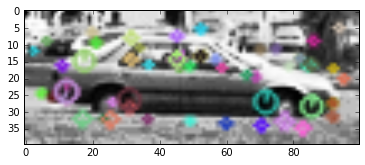

In [199]:
keypoints = detector.detect(img, None)
extractor = cv2.DescriptorExtractor_create('SIFT')
keypoints, res = extractor.compute(img, keypoints)
print res
copy = img.copy()
copy = cv2.drawKeypoints(copy,keypoints,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(copy, 'gray')
plt.show()

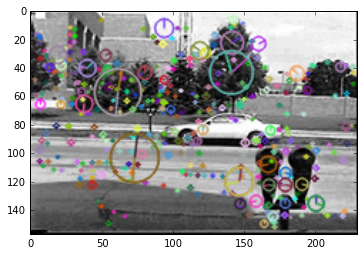

(1L, 80L)
[[ 0.00961538  0.00721154  0.00240385  0.          0.02644231  0.01201923
   0.05048077  0.05048077  0.00961538  0.00721154  0.00240385  0.00961538
   0.00480769  0.05288462  0.00721154  0.00480769  0.01201923  0.04086539
   0.01923077  0.00721154  0.00721154  0.00480769  0.          0.00961538
   0.00240385  0.01201923  0.01442308  0.01682692  0.00240385  0.00961538
   0.          0.00480769  0.00240385  0.02163462  0.01682692  0.00721154
   0.01923077  0.03605769  0.00480769  0.00961538  0.00480769  0.01442308
   0.03125     0.01201923  0.01442308  0.00721154  0.00480769  0.00721154
   0.04086539  0.00721154  0.01682692  0.01201923  0.01923077  0.01923077
   0.00480769  0.01201923  0.01682692  0.01923077  0.00480769  0.00961538
   0.01442308  0.00961538  0.00721154  0.01201923  0.00480769  0.01682692
   0.00721154  0.01682692  0.01201923  0.00721154  0.00480769  0.00721154
   0.00480769  0.01442308  0.00480769  0.00240385  0.00480769  0.01442308
   0.01442308  0.00240385]]


In [264]:
detector = cv2.SIFT()
extractor = cv2.DescriptorExtractor_create('SIFT')

bow_kmeans_trainer = cv2.BOWKMeansTrainer(300)
flann_params = dict(algorithm = 1, trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extractor = cv2.BOWImgDescriptorExtractor(extractor, matcher)

keypoints = detector.detect(img, None)
ex_keypoints, res = extractor.compute(img, keypoints)

copy = img.copy()
copy = cv2.drawKeypoints(copy,ex_keypoints,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(copy, 'gray')
plt.show()

bow_extractor.setVocabulary(VOC)
bow_keypoints = bow_extractor.compute(img, ex_keypoints)
print bow_keypoints.shape
print bow_keypoints

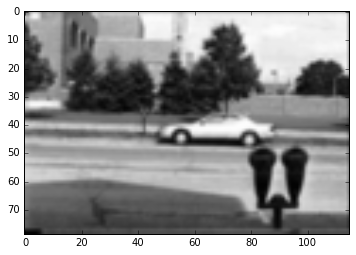

In [265]:
down = cv2.pyrDown(img)
plt.imshow(down, 'gray')
plt.show()

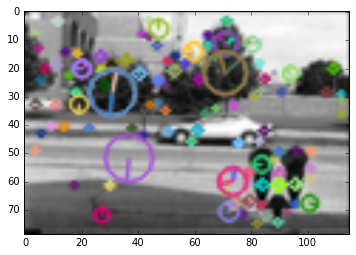

In [266]:
keypoints = detector.detect(down, None)
#keypoints, des = detector.compute(img, keypoints)
copy = down.copy()
copy = cv2.drawKeypoints(copy,keypoints,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(copy, 'gray')
plt.show()

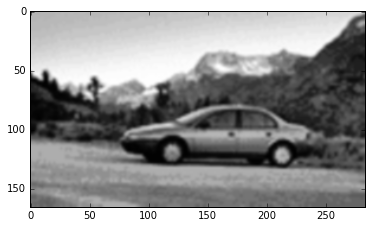

In [283]:
up = cv2.pyrUp(img)
plt.imshow(up, 'gray')
plt.show()

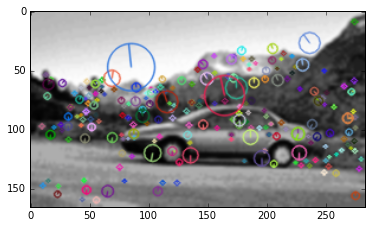

In [275]:
keypoints = detector.detect(up, None)
#keypoints, des = detector.compute(img, keypoints)
copy = up.copy()
copy = cv2.drawKeypoints(copy,keypoints,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(copy, 'gray')
plt.show()

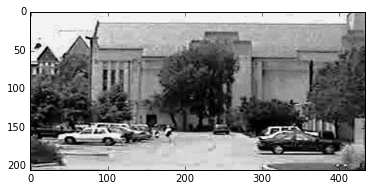

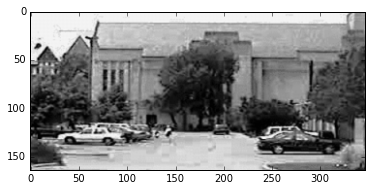

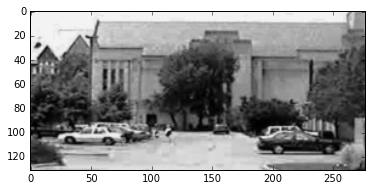

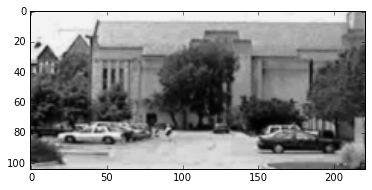

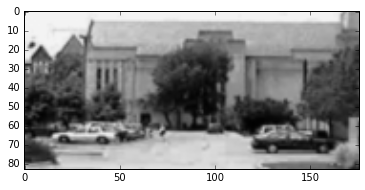

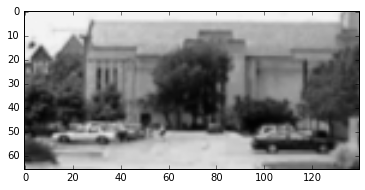

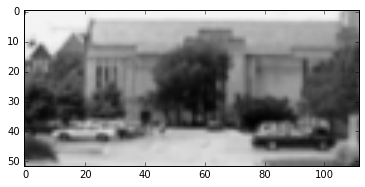

In [404]:
file_path = 'D:/objRecognition/CarData/TestImages_Scale/test-82.pgm'
img = cv2.imread(file_path)
li = get_pyramid(img, 1.25, minSize=(100,40))
for im in li:
    plt.imshow(im, 'gray')
    plt.show()

In [6]:
import os

In [7]:
pos_dir_path = 'D:/objRecognition/target/fragment2/is_target'
pos_path_list = []
for root, tree, filenames in os.walk(pos_dir_path):
    for name in filenames:
        pos_path_list.append(os.path.join(root, name))
    
print len(pos_path_list)

186


In [8]:
neg_dir_path = 'D:/objRecognition/target/fragment2/isnt_target'
neg_path_list = []
for root, tree, filenames in os.walk(neg_dir_path):
    for name in filenames:
        neg_path_list.append(os.path.join(root, name))
    
print len(neg_path_list)

694


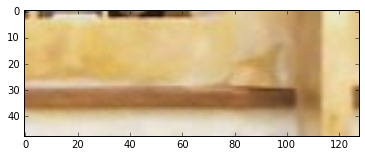

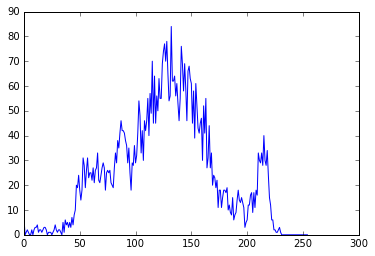

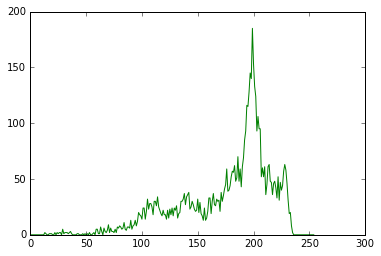

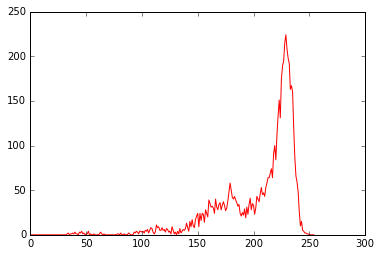

In [224]:
img = cv2.imread(pos_path_list[22])
plt.imshow(rgbImg(img))
plt.show()

B = cv2.calcHist([img], [0], None, [255], [0,255])
cv2.normalize(B, 0, 255, cv2.NORM_MINMAX)
plt.plot(B)
plt.show()

G = cv2.calcHist([img], [1], None, [255], [0,255])
cv2.normalize(G, 0, 255, cv2.NORM_MINMAX)
plt.plot(G, c='green')
plt.show()

R = cv2.calcHist([img], [2], None, [255], [0,255])
cv2.normalize(R, 0, 255, cv2.NORM_MINMAX)
plt.plot(R, c='red')
plt.show()

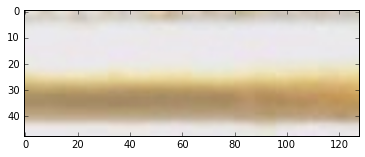

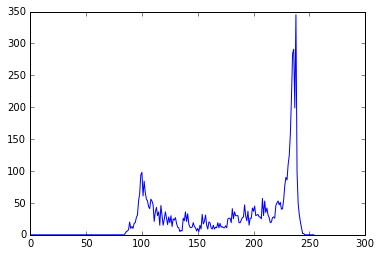

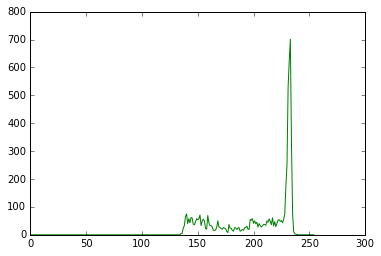

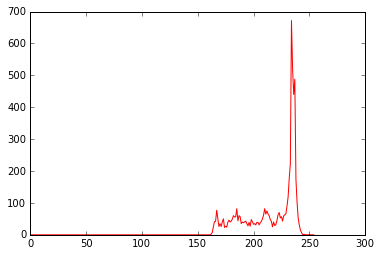

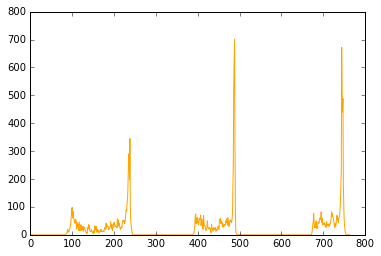

In [240]:
img = cv2.imread(neg_path_list[20])
plt.imshow(rgbImg(img))
plt.show()

B = cv2.calcHist([img], [0], None, [255], [0,255])
cv2.normalize(B, 0, 255, cv2.NORM_MINMAX)
plt.plot(B)
plt.show()

G = cv2.calcHist([img], [1], None, [255], [0,255])
cv2.normalize(G, 0, 255, cv2.NORM_MINMAX)
plt.plot(G, c='green')
plt.show()

R = cv2.calcHist([img], [2], None, [255], [0,255])
cv2.normalize(R, 0, 255, cv2.NORM_MINMAX)
plt.plot(R, c='red')
plt.show()

c = np.append(np.append(B, G), R)
plt.plot(c, c='orange')
plt.show()

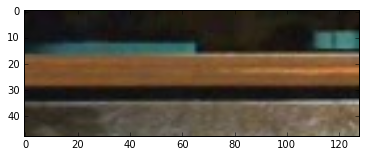

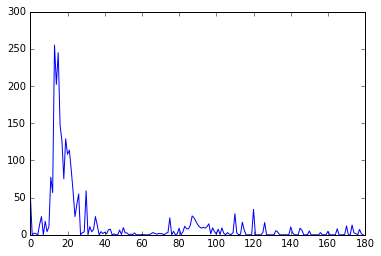

In [174]:
img = cv2.imread(pos_path_list[15])
plt.imshow(rgbImg(img))
plt.show()

#resized= cv2.resize(img, (100,100))
#plt.imshow(rgbImg(resized))
#plt.show()

cv2.split()

HSV_ROI = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
ROI_HIST = cv2.calcHist([HSV_ROI], [0], None, [180], [0,180])
Hist = ROI_HIST.copy()
cv2.normalize(ROI_HIST, Hist, 0, 255, cv2.NORM_MINMAX)
plt.plot(Hist)
plt.show()

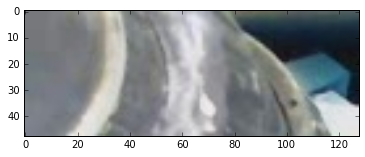

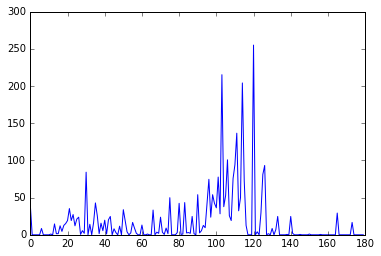

In [175]:
img = cv2.imread(neg_path_list[0])
plt.imshow(rgbImg(img))
plt.show()

#resized= cv2.resize(img, (100,100))
#plt.imshow(rgbImg(resized))
#plt.show()

HSV_ROI = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
ROI_HIST = cv2.calcHist([HSV_ROI], [0], None, [180], [0,180])
Hist = ROI_HIST.copy()
cv2.normalize(ROI_HIST, Hist, 0, 255, cv2.NORM_MINMAX)
plt.plot(Hist)
plt.show()

In [472]:
data_list = []
label_list = []
dic = dict(is_target=1, isnt_target=0)

for i in xrange(0, len(pos_path_list)):
    path = pos_path_list[i]
    #data_list.append(get_imhist(path))
    data_list.append(get_RGBhist(path))
    label_list.append('1')

for i in xrange(0, len(neg_path_list)):
    path = neg_path_list[i]
    #data_list.append(get_imhist(path))
    data_list.append(get_RGBhist(path))
    label_list.append('-1')

trainingDataMat = np.array(data_list, np.float32)
labelsMat = np.array(label_list, np.int32)

In [477]:
svm_param = dict(svm_type=cv2.SVM_C_SVC, kernel_type=cv2.SVM_LINEAR, gamma=0.5, Cvalue=40)
svm = cv2.SVM()
svm.train(trainingDataMat, labelsMat, params=svm_param)
svm.save('D:/objRecognition/target_SVM2.model')

In [479]:
# pos 2062; neg 3060

svm.load('D:/objRecognition/target_SVM2.model')
count = 0.0

for path in pos_path_list:
    pos_pred = svm.predict(get_RGBhist(path), returnDFVal=True)
    #print pos_pred,
    if pos_pred <= -1.0 :
        count +=1
print count/len(pos_path_list)*100, '%'

count = 0.0
for path in neg_path_list:
    neg_pred = svm.predict(get_RGBhist(path), returnDFVal=True)
    #print neg_pred,
    if neg_pred >= 1.0 :
        count +=1
print count/len(neg_path_list)*100, '%'

73.6559139785 %
84.1498559078 %


0.0
3.16681289673


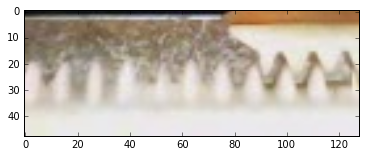

In [337]:
i = 23
print svm.predict(get_RGBhist(pos_path_list[i]), returnDFVal=False)
print svm.predict(get_RGBhist(pos_path_list[i]), returnDFVal=True)

plt.imshow(rgbImg(cv2.imread(pos_path_list[i])))
plt.show()

In [480]:
class Target():
    global SVM
    SVM = cv2.SVM()
    SVM.load('D:/objRecognition/target_SVM.model')
    
    def __init__(self, id, frame, track_window):
        self.id = id
        x, y, w, h = track_window
        self.track_window = track_window
        self.ROI = cv2.cvtColor(frame[y:y+h, x:x+w], cv2.COLOR_BGR2HSV)
        ROI_HIST = cv2.calcHist([self.ROI], [0], None, [16], [0, 180])
        self.ROI_HIST = cv2.normalize(ROI_HIST, ROI_HIST, 0, 255, cv2.NORM_MINMAX)
        self.kalman = cv3.KalmanFilter(4, 2)
        self.kalman.measurementMatrix = np.array([[1,0,0,0], [0,1,0,0]], np.float32)
        self.kalman.transitionMatrix = np.array([[1,0,1,0], [0,1,0,1], [0,0,1,0],[0,0,0,1]], np.float32)
        self.kalman.processNoiseCov = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0],[0,0,0,1]], np.float32)*0.03
        self.prediction = np.array((2,1), np.float32)
        self.measurement = np.array((2,1), np.float32)
        self.term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
        self.center = None
        self.past_x = None
        self.frame_count = 0
        self.error_count = 0
        self.STATUS = False
        self.update(frame)
        self.predicted_value = 0
        
    #def __del__(self):
        #print "Target %d is out-of-bounds" % self.id
    
    def get_center(self, points):
        """calculates centroid of a given matrix"""
        x = (points[0][0] + points[1][0] + points[2][0] + points[3][0]) / 4
        y = (points[0][1] + points[1][1] + points[2][1] + points[3][1]) / 4
        return np.array([np.float32(x), np.float32(y)], np.float32)
    
    def update(self, frame):
        w, h = 40, 40
        font = cv2.FONT_HERSHEY_SIMPLEX
        if self.frame_count%20 ==0:
            for (x, y, roi) in sliding_window(frame, 10, (w, h)):
                if roi.shape[1] != w or roi.shape[0] != h:
                    continue
                self.predicted_value = SVM.predict(self.get_imhist(roi), returnDFVal=True)
                if self.predicted_value <= -0.5:
                    cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 1)
                    #cv2.putText(frame, 'ID: %d%s' % (self.id, self.center), (x, y-1), font, 0.6, (0,255,0), 1, cv3.LINE_AA)
                    cv2.putText(frame, '%s' % (self.predicted_value), (x, y-1), font, 0.6, (0,255,0), 1, cv3.LINE_AA)

                    if self.error_count >= 5:
                        self.STATUS = True
                        self.error_count = 0

                    if self.STATUS == True:
                        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 2)
                        cv2.putText(frame, 'ID: %d%s' % (self.id, self.center), (x, y-1), font, 0.6, (0,0,255), 1, cv3.LINE_AA)
        self.frame_count += 1
        #self.kalman.correct(self.center)
        #prediction = self.kalman.predict()
        #cv2.circle(frame, (int(prediction[0]), int(prediction[1])), 4, (0,255,0), -1)
        
        #cv2.putText(frame, 'ID: %d -> %s' % (self.id, self.center), (11, (self.id+1)*25+1), font, 0.6, (0,0,0), 1, cv3.LINE_AA)
        #cv2.putText(frame, 'ID: %d -> %s' % (self.id, self.center), (11, (self.id+1)*25), font, 0.6, (255,255,0), 1, cv3.LINE_AA)
    
    def get_imhist(self, img):
        resized= cv2.resize(img, (100,100))
        HSV_ROI = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
        ROI_HIST = cv2.calcHist([HSV_ROI], [0], None, [180], [0,180])
        Hist = ROI_HIST.copy()
        cv2.normalize(ROI_HIST, Hist, 0, 255, cv2.NORM_MINMAX)
        return Hist
    
    def non_max_suppression(self, boxes, overlapThresh):
        if len(boxes) == 0:
            return []
        
        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        pick = []
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]

        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)
        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)
            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)
            overlap = (w * h) / area[idxs[:last]]

            idxs = np.delete(idxs, np.concatenate(([last],
                np.where(overlap > overlapThresh)[0])))
        return boxes[pick].astype("float")

In [481]:
def main(VIDEO_PATH):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.namedWindow('surveillance')
    targets = []
    frame_num = 0
    scale = 1
    camera = cv2.VideoCapture(VIDEO_PATH)
    
    SVM = cv2.SVM()
    SVM.load('D:/objRecognition/target_SVM2.model')
    
    cols, rows = (int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH)),   
        int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT)))
    
    w = cols/5  
    h = rows/10
    step = rows/20
    
    fourcc = cv2.cv.CV_FOURCC('m', 'p', '4', '2')
    output = cv2.VideoWriter('D:/objTracking/raspberry_pi/video_target/objTrackingTest8.avi',fourcc, 20.0, (cols, rows))
    
    FPS_NUM = 0
    try:
        while True:
            grabbed, frame = camera.read()
            if grabbed == False:
                print 'failed to grab frame'
                break

            ret, frame = camera.read()
            if frame_num%1 ==0:
                for (x, y, roi) in sliding_window(frame, step, (w, h)):
                    if roi.shape[1] != w or roi.shape[0] != h:
                        continue
                    predicted_value = SVM.predict(get_RGBhist(roi), returnDFVal=True)
                    if predicted_value <= -3.0:
                        rx, ry, rx2, ry2 = int(x * scale), int(y * scale), int((x+w) * scale), int((y+h) * scale)
                        targets.append([rx, ry, rx2, ry2, abs(predicted_value)])
                        #cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 1)
                        #cv2.putText(frame, 'ID: %d%s' % (self.id, self.center), (x, y-1), font, 0.6, (0,255,0), 1, cv3.LINE_AA)
                        #cv2.putText(frame, '%s' % (self.predicted_value), (x, y-1), font, 0.6, (0,255,0), 1, cv3.LINE_AA)

            windows = np.array(targets)
            boxes = non_max_suppression(windows, overlapThresh=0.05)
            for (x, y, x2, y2, result) in boxes:
                cv2.rectangle(frame, (int(x),int(y)),(int(x2), int(y2)),(0, 255, 0), 1)
                cv2.putText(frame, "%f" % result, (int(x),int(y)), font, 1, (0, 255, 0))

            frame_num += 1
            #output.write(frame)

            cv2.imshow('surveillance', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        output.release()
        camera.release()
        cv2.destroyAllWindows()

In [3]:
import os
video_path_list = []
VIDEO_PATH = 'D:/objRecognition/target/video/'
for root, tree, names in os.walk(VIDEO_PATH):
    for name in names:
        video_path_list.append(os.path.join(root, name))

In [4]:
print len(video_path_list)

9


In [489]:
if __name__ == "__main__":
    main()

In [26]:
cv2.destroyAllWindows()
camera.release()

Target 0 is out-of-bounds


NameError: name 'camera' is not defined

In [516]:
camera = cv2.VideoCapture('D:/objRecognition/target/video/3_gg_2017-02-02_15_31_38_reset.avi')
cols, rows = (int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH)),   
        int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT)))
    
w = cols/5  
h = rows/10
step = rows/15

count = 0
for i in xrange(0,10):
    grabbed, frame = camera.read()

while count<2:
    i = 0
    grabbed, frame = camera.read()
    for (x, y, roi) in sliding_window(frame, step, (w, h)):
        if roi.shape[1] != w or roi.shape[0] != h:
                    continue
        cv2.imwrite('D:/objRecognition/target/fragment2/e{}-{}.jpg'.format(count, i), roi)
        i += 1
        
    count += 1
    
camera.release()

In [5]:


class Target():
    def __init__(self, ID, frame, track_window):
        self.ID = ID
#         print ID
        (self.x, self.y, self.w, self.h) = track_window
        
        resized = cv2.resize(frame[self.y:self.y+self.h, self.x:self.x+self.w], (20, 20))
        
        self.track_window = track_window
        ROI_HIST = cv2.calcHist(
            [resized], [0], None, [255], [0, 255])
        self.ROI_HIST = cv2.normalize(ROI_HIST, ROI_HIST, 0, 255, cv2.NORM_MINMAX)
        self.term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
        self.center = None
        self.past_x = None
        self.past_y = None
        self.past_w = None
        self.past_h = None
        self.frame_count = 0
        self.error_count = 0
        self.is_stoped = False
        self.update(frame, track_window)
        
    def __del__(self):
        print "Target %d is out-of-bounds" % self.ID
        #pass
    
    def get_center(self, points):
        """calculates centroid of a given matrix"""
        x = (points[0][0] + points[1][0] + points[2][0] + points[3][0]) / 4
        y = (points[0][1] + points[1][1] + points[2][1] + points[3][1]) / 4
        return np.array([np.float32(x), np.float32(y)], np.float32)
    
    def update(self, frame, track_window):
        font = cv2.FONT_HERSHEY_SIMPLEX
#         print self.x, self.y, self.w, self.h
        # update coordinators
        self.past_x = self.x
        self.past_y = self.y
        self.past_w = self.w
        self.past_h = self.h
        self.x, self.y, self.w, self.h = track_window
        
        self.center = self.get_center(
            [[self.x, self.y], 
             [self.x+self.w, self.y], 
             [self.x, self.y+self.h], 
             [self.x+self.w, self.y+self.h]])
        
        if self.frame_count%30 == 0:
            diff = abs(self.x-self.past_x)
            if diff <5:
                self.error_count += 1    
            else:
                self.error_count = 0
                self.is_stoped = False
        
        self.frame_count += 1
        cv2.rectangle(
            frame, (self.x, self.y), (self.x + self.w, self.y + self.h), (0,255,0), 1)
        cv2.putText(
                frame, 
                'ID: %d%s' % (self.ID, self.center), 
                (self.x, self.y-1), font, 0.6, (0,255,0), 1)
        
        if self.error_count >= 5:
            self.is_stoped = True
            self.error_count = 0
            
        if self.is_stoped == True:
            cv2.rectangle(
                frame, (self.x, self.y), (self.x + self.w, self.y + self.h), (0,0,255), 2)
            cv2.putText(
                frame, 
                'ID: %d%s' % (self.ID, self.center), 
                (self.x, self.y-1), font, 0.6, (0,0,255), 1)
        else:
            cv2.rectangle(
                frame, (self.x, self.y), (self.x + self.w, self.y + self.h), (0,255,0), 1)
        
    def get_similarity(self, hist):
        return (cosine_similarity(self.ROI_HIST.reshape(1, -1), hist.reshape(1, -1))>0.6)
    
    

In [6]:
def main(VIDEO_PATH):
    bs = cv2.BackgroundSubtractorMOG2(history=10, varThreshold=15.0, bShadowDetection=False)

    cv2.namedWindow('surveillance')
    targets = {}
    frames = 0
    camera = cv2.VideoCapture(VIDEO_PATH)
    
    cols, rows = (int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH)),   
        int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT)))
    
    fourcc = cv2.cv.CV_FOURCC('m', 'p', '4', '2')
    output = cv2.VideoWriter('D:/objTracking/raspberry_pi/video_target/objTrackingTest8.avi',fourcc, 20.0, (cols, rows))
    
    for i in xrange(0,20):
        ret, frame = camera.read()
    
    FPS_NUM = 0
    while True:
        grabbed, frame = camera.read()
        if grabbed == False:
            print 'failed to grab frame'
            break
        
        ret, frame = camera.read()
        bl = cv2.medianBlur(frame, 5)
        fgmask = bs.apply(bl, learningRate=0.008)
        try:
            bl = cv2.medianBlur(fgmask.copy(), 5)
            th = cv2.threshold(bl, 127, 255, cv2.THRESH_BINARY)[1]
            th = cv2.erode(th, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)), iterations = 2)
            dilated = cv2.dilate(th, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 2)
            cv2.imshow('dilated', dilated)
            contours, hier = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        except AttributeError:
            continue

        
        if len(targets) == 0:
            #ID = 0
            #for c in contours:
            #    if cv2.contourArea(c)>1000:
            #        (x,y,w,h) = cv2.boundingRect(c)
            #        cv2.rectangle(frame, (x, y), (x+w, y+h), (255,0,0), 1)
            #        targets[ID] = Target(ID, frame, (x, y, w, h))
            #        ID += 1
            for i in xrange(0, 10):
                targets[i] = None
            
        else:
            for c in contours:
                is_tracked = False
                c_area = cv2.contourArea(c)
                if c_area >1000:
                    parms = get_contour_parm(c)

                    for i, val in enumerate(parms):
                        if val <= 0:
                            parms[i] = 1

                    (x, y, w, h) = parms
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 1)
                    resized = cv2.resize(frame[y:y+h, x:x+w], (20, 20))
                    hist = cv2.calcHist([resized], [0], None, [255], [0, 255])
                    nor_hist = cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
                    try:
                        for i in xrange(0, len(targets)):
                            if targets[i].get_similarity(nor_hist):
                                targets[i].update(frame, (x, y, w, h))
                                is_tracked = True
                        if not is_tracked:
                            #ID = len(targets)
                            ID += ID
                            targets[ID] = Target(ID, frame, (x, y, w, h))
                    except:
                        pass

        #output.write(frame)
        
        cv2.imshow('surveillance', frame)
        cv2.imshow('mask', fgmask)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    output.release()
    camera.release()
    cv2.destroyAllWindows()

In [8]:
if __name__ == "__main__":
    main(video_path_list[8])

In [190]:
cv2.destroyAllWindows()
camera.release()

Target 0 is out-of-bounds


NameError: name 'camera' is not defined

In [18]:
class Target():
    def __init__(self, id, frame, track_window):
        self.id = id
        x, y, w, h = track_window
        self.track_window = track_window
        #self.ROI = cv2.cvtColor(frame[y:y+h, x:x+w], cv2.COLOR_BGR2HSV)
        ROI_HIST = cv2.calcHist([frame], [0], None, [255], [0, 255])
        self.ROI_HIST = cv2.normalize(ROI_HIST, ROI_HIST, 0, 255, cv2.NORM_MINMAX)
        self.kalman = cv3.KalmanFilter(4, 2)
        self.kalman.measurementMatrix = np.array([[1,0,0,0], [0,1,0,0]], np.float32)
        self.kalman.transitionMatrix = np.array([[1,0,1,0], [0,1,0,1], [0,0,1,0],[0,0,0,1]], np.float32)
        self.kalman.processNoiseCov = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0],[0,0,0,1]], np.float32)*0.03
        self.prediction = np.array((2,1), np.float32)
        self.measurement = np.array((2,1), np.float32)
        self.term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
        self.center = None
        self.past_x = None
        self.past_y = None
        self.past_w = None
        self.past_h = None
        self.frame_count = 0
        self.error_count = 0
        self.STATUS = False
        self.update(frame)
        
    def __del__(self):
        print "Target %d is out-of-bounds" % self.id
    
    def get_center(self, points):
        """calculates centroid of a given matrix"""
        x = (points[0][0] + points[1][0] + points[2][0] + points[3][0]) / 4
        y = (points[0][1] + points[1][1] + points[2][1] + points[3][1]) / 4
        return np.array([np.float32(x), np.float32(y)], np.float32)
    
    def update(self, frame):
        font = cv2.FONT_HERSHEY_SIMPLEX
        #HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        back_project = cv2.calcBackProject([frame], [0], self.ROI_HIST, [0, 255], 1)
        
        ret, self.track_window = cv2.meanShift(back_project, self.track_window, self.term_crit)
        x, y, w, h = self.track_window
        
        if self.past_x is None:
            self.past_x = x
            self.past_y = y
            self.past_w = w
            self.past_h = h
        
        self.center = self.get_center([[x,y], [x+w,y], [x,y+h], [x+w,y+h]])
        if self.frame_count%10 == 0:
            diff = abs(x-self.past_x)
            #print 'ID=', self.id, 'x=', x, 'past_x=', self.past_x, 'diff=', diff,
            if diff <5:
                self.error_count += 1    
            else:
                self.error_count = 0
                self.STATUS = False
            #print 'error_count=', self.error_count, 'STATUS=', self.STATUS
        self.past_x = x
        self.past_y = y
        self.past_w = w
        self.past_h = h
        
        #cv2.imwrite('D:/objRecognition/target/fragment/frag_e{}.jpg'.format(self.frame_count), frame[y:y+h, x:x+w])
        self.frame_count += 1
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 1)
        #cv2.putText(frame, 'ID: %d%s' % (self.id, self.center), (x, y-1), font, 0.6, (0,255,0), 1, cv3.LINE_AA)
        
        
        if self.error_count >= 5:
            self.STATUS = True
            self.error_count = 0
            
        if self.STATUS == True:
            cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 2)
            cv2.putText(frame, 'ID: %d%s' % (self.id, self.center), (x, y-1), font, 0.6, (0,0,255), 1, cv3.LINE_AA)
        
        #self.kalman.correct(self.center)
        #prediction = self.kalman.predict()
        #cv2.circle(frame, (int(prediction[0]), int(prediction[1])), 4, (0,255,0), -1)
        
        
        
        #cv2.putText(frame, 'ID: %d -> %s' % (self.id, self.center), (11, (self.id+1)*25+1), font, 0.6, (0,0,0), 1, cv3.LINE_AA)
        #cv2.putText(frame, 'ID: %d -> %s' % (self.id, self.center), (11, (self.id+1)*25), font, 0.6, (255,255,0), 1, cv3.LINE_AA)
        

def main(VIDEO_PATH):
    history = 20
    #bs = cv3.createBackgroundSubtractorKNN(detectShadows = True)
    #bs.setHistory(history)
    bs = cv2.BackgroundSubtractorMOG2(history=20, varThreshold=15.0, bShadowDetection=False)
    

    cv2.namedWindow('surveillance')
    target = {}
    firstframe = True
    frames = 0
    camera = cv2.VideoCapture(VIDEO_PATH)
    
    cols, rows = (int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH)),   
        int(camera.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT)))
    
    fourcc = cv2.cv.CV_FOURCC('m', 'p', '4', '2')
    output = cv2.VideoWriter('D:/objTracking/raspberry_pi/video_target/objTrackingTest8.avi',fourcc, 20.0, (cols, rows))
    
    for i in xrange(0,10):
        ret, frame = camera.read()
    
    
    FPS_NUM = 0
    while True:
        #print '------------------- FRAME %d ---------------------' % frames
        grabbed, frame = camera.read()
        if grabbed == False:
            print 'failed to grab frame'
            break
        
        ret, frame = camera.read()
        bl = cv2.medianBlur(frame, 5)
        fgmask = bs.apply(bl, learningRate=0.008)
        if frames < history:
            frames += 1
            continue
        try:
            bl = cv2.medianBlur(fgmask.copy(), 5)
            th = cv2.threshold(bl, 127, 255, cv2.THRESH_BINARY)[1]
            th = cv2.erode(th, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)), iterations = 2)
            dilated = cv2.dilate(th, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 2)
            cv2.imshow('dilated', dilated)
            contours, hier = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        except AttributeError:
            continue

        counter = 0
        for c in contours:
            if cv2.contourArea(c)>1000:
                (x,y,w,h) = cv2.boundingRect(c)
                if True:
                    cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 1)

                    if firstframe == True:
                        target[counter] = Target(counter, frame, (x,y,w,h))
                        counter += 1

        for i, p in target.iteritems():
            p.update(frame)

        firstframe = False
        frames += 1
        
        #output.write(frame)
        
        cv2.imshow('surveillance', frame)
        cv2.imshow('mask', fgmask)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    output.release()
    camera.release()
    cv2.destroyAllWindows()
    
    
if __name__ == "__main__":
    main(video_path_list[1])

Target 0 is out-of-bounds
Target 1 is out-of-bounds
Target 2 is out-of-bounds
Target 3 is out-of-bounds
Target 4 is out-of-bounds
Target 5 is out-of-bounds
Target 6 is out-of-bounds
Target 7 is out-of-bounds


In [10]:
cv2.destroyAllWindows()
camera.release()

Target 0 is out-of-bounds


NameError: name 'camera' is not defined

In [21]:
a = 2

In [23]:
assert a==1, 'a==1'

AssertionError: a==1